In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np
import torch

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [233]:
import torch.nn as nn
import torch.nn.functional as F

class TVGL(nn.Module):
    def __init__(self, inp, lam=0, beta=1e2, dim=10):
        super(TVGL, self).__init__()
        m = inp.shape[0]
        n = inp.shape[1]
        self.base = torch.eye(n).float().cuda()
        self.base = nn.Parameter(self.base)
        self.trs = torch.randn(m,n,dim).float().cuda()/264
        self.trs = nn.Parameter(self.trs)
        self.lam = lam
        self.beta = beta
        self.eye = torch.eye(S.shape[1]).float().cuda()
        
    def forward(self, S):
        trs = torch.einsum('abc,adc->abd',self.trs,self.trs)
        thetas = trs #torch.einsum('abd,de->abe',trs,self.base)
        sim = torch.sum((S-thetas)**2)
        diff = self.beta*torch.sum((thetas[1:]-thetas[:-1])**2)
        l2 = self.lam*torch.sum(self.trs**2)
        return [sim,diff,l2]
    
nEpochs = 4000
pPeriod = 100

nt = nback_t.shape[-1]
X = nback_t[0].T
win = 5
S = torch.zeros(nt-2*win,264,264).float().cuda()
for tp in range(win,nt-win):
    S[tp-win] = X[tp-win:tp+win].T@X[tp-win:tp+win]

tvgl = TVGL(S,lam=0,beta=5e2,dim=90)
optim = torch.optim.Adam(tvgl.parameters(), lr=1e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3, factor=0.9)

for epoch in range(nEpochs):
    loss = tvgl(S)
    sum(loss).backward()
    optim.step()
    sched.step(loss[0])
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {[float(part) for part in loss]}')
        
print('Complete')

0 [41272.9609375, 285.25250244140625, 0.0]
100 [37181.8046875, 2887.83935546875, 0.0]
200 [35199.9765625, 35283.63671875, 0.0]
300 [35692.203125, 12396.056640625, 0.0]
400 [35711.3828125, 10503.048828125, 0.0]
500 [35712.1484375, 10248.4931640625, 0.0]
600 [35712.26171875, 10010.93359375, 0.0]
700 [35712.15234375, 9781.830078125, 0.0]
800 [35711.984375, 9562.0439453125, 0.0]
900 [35711.8125, 9351.2490234375, 0.0]


KeyboardInterrupt: 

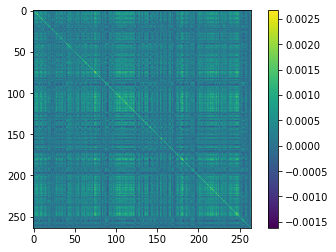

In [235]:
import matplotlib.pyplot as plt

trs = torch.einsum('abc,adc->abd',tvgl.trs,tvgl.trs)
# thetas = torch.einsum('abd,de->abe',trs,tvgl.base)
thetas = trs #+ tvgl.base.unsqueeze(0)

# plt.imshow(den.detach().cpu().numpy())
plt.imshow(thetas[20].detach().cpu().numpy())
# plt.imshow(torch.linalg.inv(thetas[30]).detach().cpu().numpy())
plt.colorbar()
plt.show()

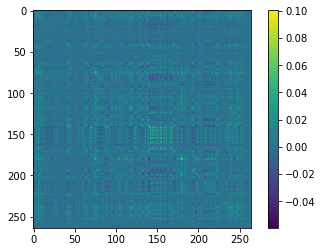

In [236]:
plt.imshow(S[20].detach().cpu().numpy())
plt.colorbar()
plt.show()

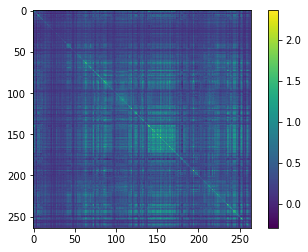

In [223]:
plt.imshow(nback[0]@nback[0].T)
plt.colorbar()
plt.show()